In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [ ]:
spark.read.csv("Customer.csv",header=True).createOrReplaceTempView("Customers")
spark.read.csv("DetailTransaction.csv",header=True).createOrReplaceTempView("DetailTransactions")
spark.read.csv("HeaderTransaction.csv",header=True).createOrReplaceTempView("HeaderTransactions")
spark.read.csv("Jacket.csv",header=True).createOrReplaceTempView("Jackets")
spark.read.csv("JacketType.csv",header=True).createOrReplaceTempView("JacketTypes")
spark.read.csv("Staff.csv",header=True).createOrReplaceTempView("Staffs")

In [ ]:
data = spark.sql("""
select jt.jackettypename, sum(j.price*dt.quantity) as revenue 
from JacketTypes jt JOIN
jackets j ON jt.jackettypeid = j.jackettypeid JOIN
detailtransactions dt ON j.jacketid = dt.jacketid JOIN
headertransactions ht ON ht.transactionid = dt.transactionid
where j.price > 500000
group by jackettypename
""").toPandas()

size = [0, 0, 0, 0, 0, 0.05, 0]

plt.pie(data["revenue"],labels=data["jackettypename"],autopct="%.2f%%", explode=size)
plt.title("percentage of jacket type sold with price above 500000")
plt.show

<function matplotlib.pyplot.show>

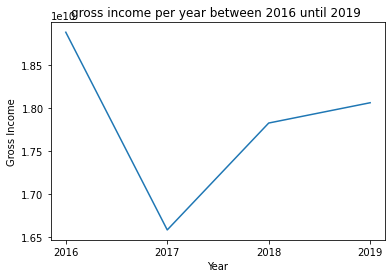

In [ ]:
data = spark.sql("""
select year(transactiondate) as Year, sum(quantity*price) as Gross_Income 
from jackets j JOIN
detailtransactions dt ON dt.jacketid = j.jacketid JOIN
headertransactions ht ON dt.transactionid = ht.transactionid
where year(ht.transactiondate) between 2016 and 2019
group by year(transactiondate)
order by year(transactiondate)
""").toPandas()

plt.plot(data["Year"], data["Gross_Income"])
plt.title("gross income per year between 2016 until 2019 ")
plt.xticks(range(2016,2020))
plt.xlabel("Year")
plt.ylabel("Gross Income")
plt.show


<function matplotlib.pyplot.show>

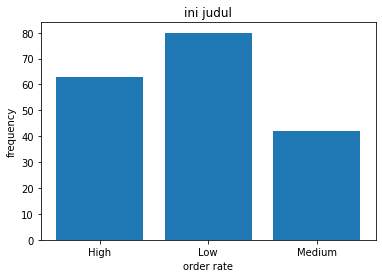

In [ ]:
data = spark.sql("""

select ordermonth,
count(*) as count
from(
  select dt.transactionid, month(ht.transactiondate) as bulan,sum(j.jacketid*quantity) as spend,
case 
  when sum(j.jacketid*quantity) > 4000 then 'High'
  when sum(j.jacketid*quantity) between 2501 and 4000 then 'Medium'
  when sum(j.jacketid*quantity) <= 2500 then 'Low'
end as ordermonth 
from jackets j JOIN
  detailtransactions dt ON dt.jacketid = j.jacketid JOIN
  headertransactions ht ON ht.transactionid=dt.transactionid
  where Year(ht.transactiondate) = 2019
  group by dt.transactionid, bulan
  order by spend asc
)
group by ordermonth
order by ordermonth
""").toPandas()

plt.bar(data["ordermonth"],data["count"])
plt.title("ini judul")
plt.xlabel("order rate")
plt.ylabel("frequency")
plt.show

In [ ]:
#load data
testing = spark.read.csv("Test.csv",header=True, inferSchema=True)
training = spark.read.csv("Train.csv",header=True, inferSchema=True)



In [ ]:
columns=["Insulin", "Glucose", "DiabetesPedigreeFunction"]

#buat buang data null
training=training.na.drop()
testing=testing.na.drop()

# select features
testing=testing.select("Insulin", "Glucose", "DiabetesPedigreeFunction","Outcome") 
training=training.select(columns)

#transform data
from pyspark.sql.functions import when


testing=testing.withColumn(
    "Outcome",
    when(testing["Outcome"]=="No",0).
    otherwise(1)
)

#normalization
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=columns, outputCol="assembled")
testing=assembler.transform(testing)
training=assembler.transform(training)

scaler = StandardScaler(inputCol="assembled",outputCol="features")
testing=scaler.fit(testing).transform(testing)
training=scaler.fit(training).transform(training)





In [ ]:
#generate model
from pyspark.ml.clustering import KMeans

#jumlah cluster
kmeans = KMeans(k=2)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()


ACCURACY:91.01479915433404%


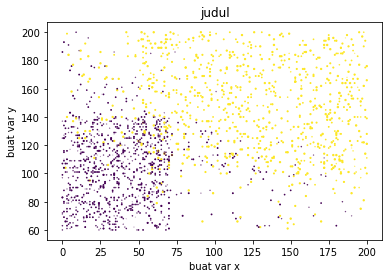

In [ ]:


plt.scatter(
    data["Insulin"],
    data["Glucose"],
    data["DiabetesPedigreeFunction"],
    c=data["prediction"]
)
plt.title("judul")
plt.xlabel("buat var x")
plt.ylabel("buat var y")
plt.show

c=0
for idx, row in data.iterrows():
  if row["Outcome"] == row["prediction"]:
    c+=1

acc=c/ len(data)*100
print(f'ACCURACY:{acc}%')


